## 1. Carga de librerias, modelos y herramientas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [2]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

In [3]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_touch214.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_humidity = pretreat_data_df(df_test, 'humidity')
df_co2 = pretreat_data_df(df_test, 'CO2')

len(df_temperature), len(df_humidity), len(df_co2)

(122306, 155954, 162243)

In [4]:
df_temperature.head()

,temperature
timestamp,
2023-03-03 09:31:00,18.1
2023-03-03 09:32:00,18.2
2023-03-03 09:33:00,18.3
2023-03-03 09:34:00,18.4
2023-03-03 09:37:00,18.7


In [5]:
df_co2.head()

,CO2
timestamp,
2023-03-03 09:30:00,601.92
2023-03-03 09:31:00,638.08
2023-03-03 09:32:00,673.28
2023-03-03 09:33:00,691.20
2023-03-03 09:34:00,730.88


In [6]:
df_humidity.head()

,humidity
timestamp,
2023-03-03 09:31:00,26.6
2023-03-03 09:32:00,26.8
2023-03-03 09:33:00,26.9
2023-03-03 09:34:00,26.8
2023-03-03 09:35:00,27.1


In [7]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Touch 214 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Touch 214 ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2023-03-05'])
    plt.title('1 day Touch 214 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

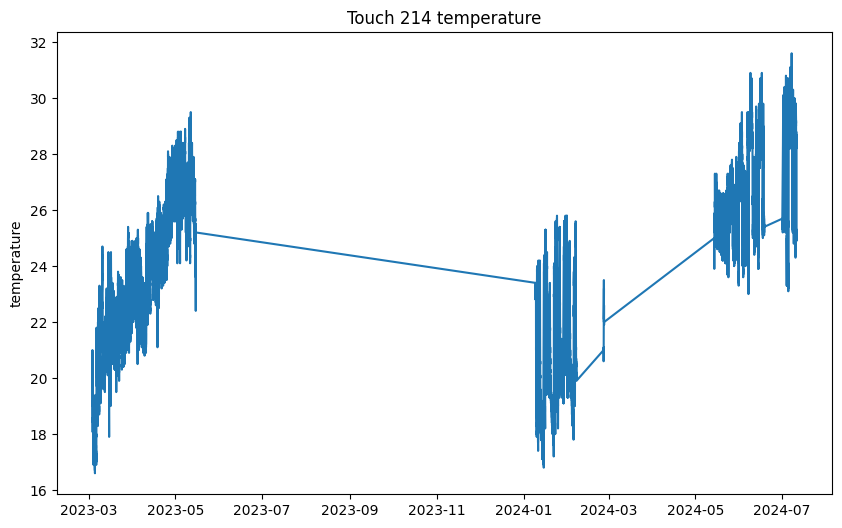

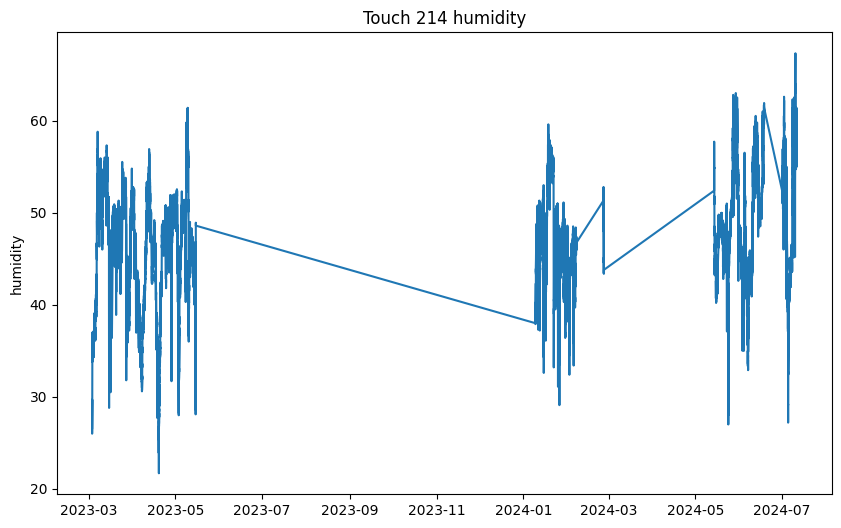

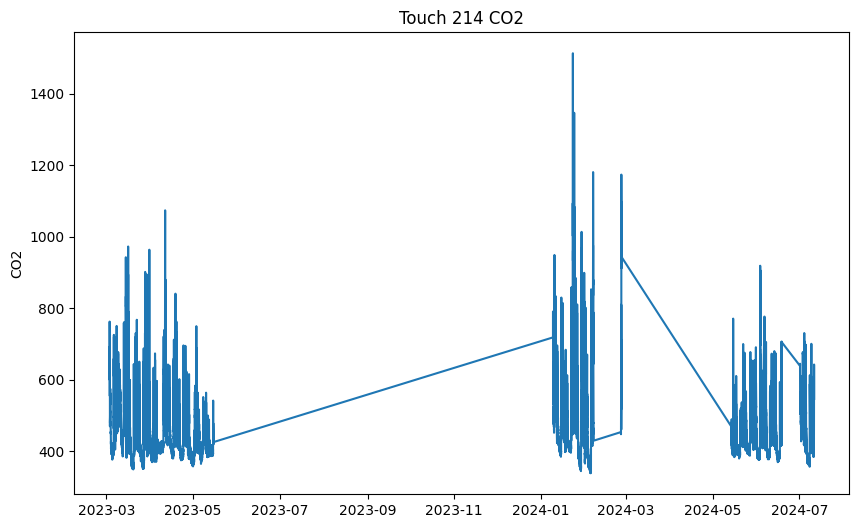

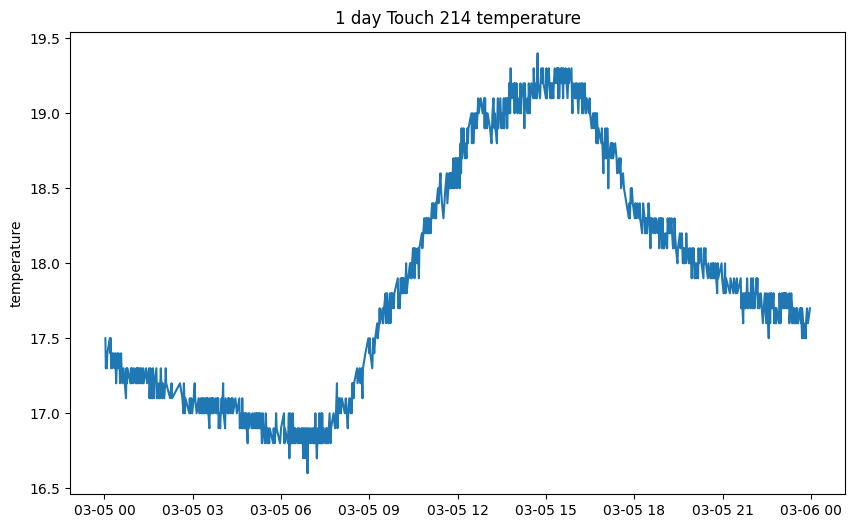

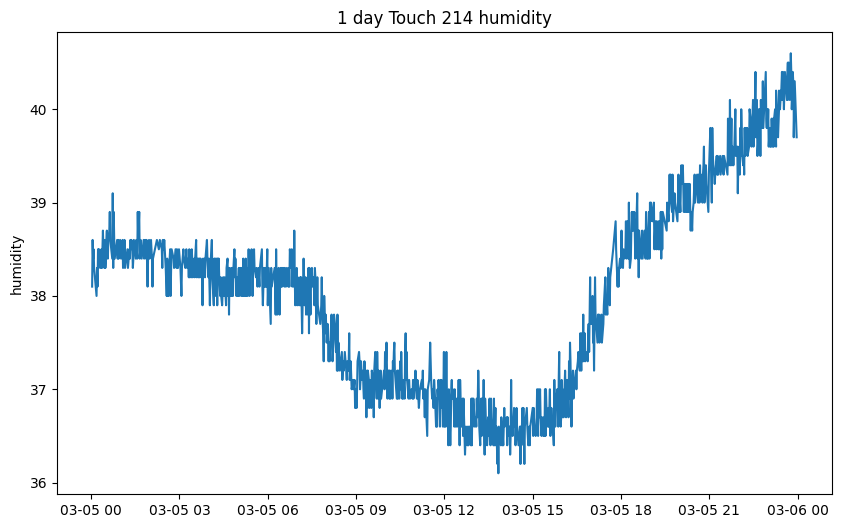

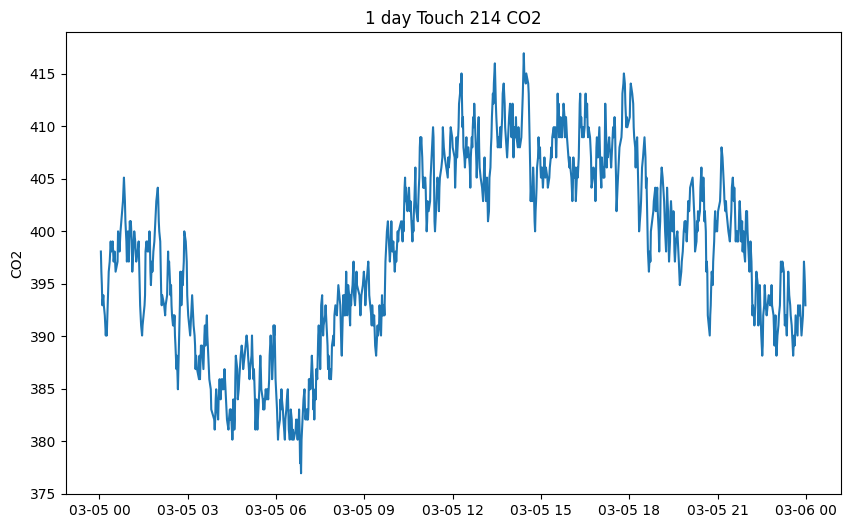

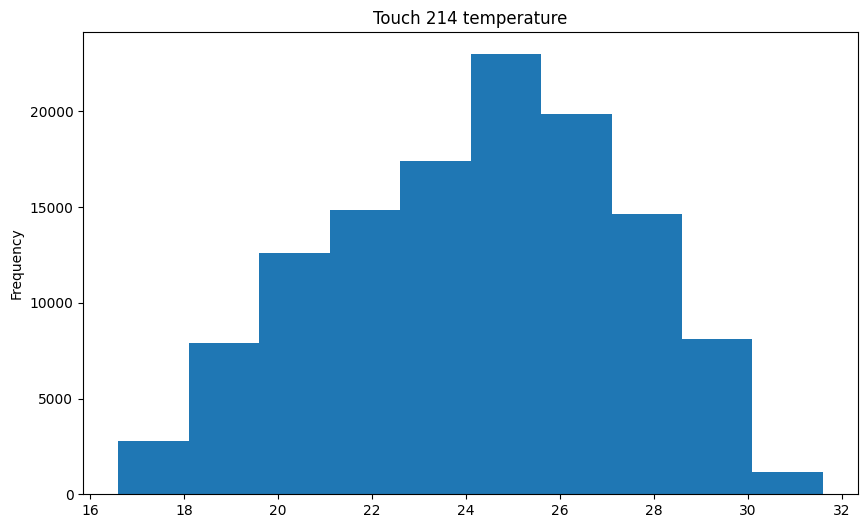

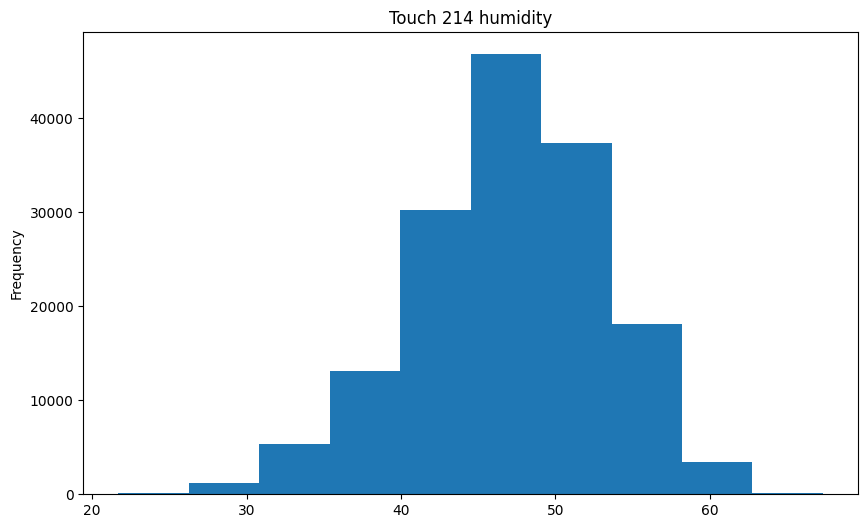

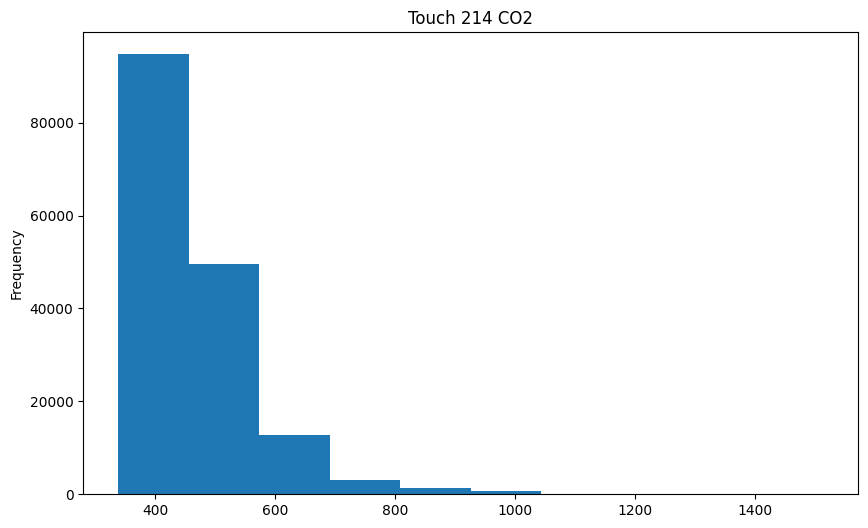

In [8]:
plot_data(df_temperature, 'temperature')
plot_data(df_humidity, 'humidity')
plot_data(df_co2, 'CO2')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_humidity, 'humidity')
plot_day_data(df_co2, 'CO2')
plot_hist(df_temperature, 'temperature')
plot_hist(df_humidity, 'humidity')
plot_hist(df_co2, 'CO2')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [9]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [10]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_humidity = reduce_df(df_humidity, '2023-03-01', '2023-05-15')
reduced_df_co2 = reduce_df(df_co2, '2023-03-01', '2023-05-15')

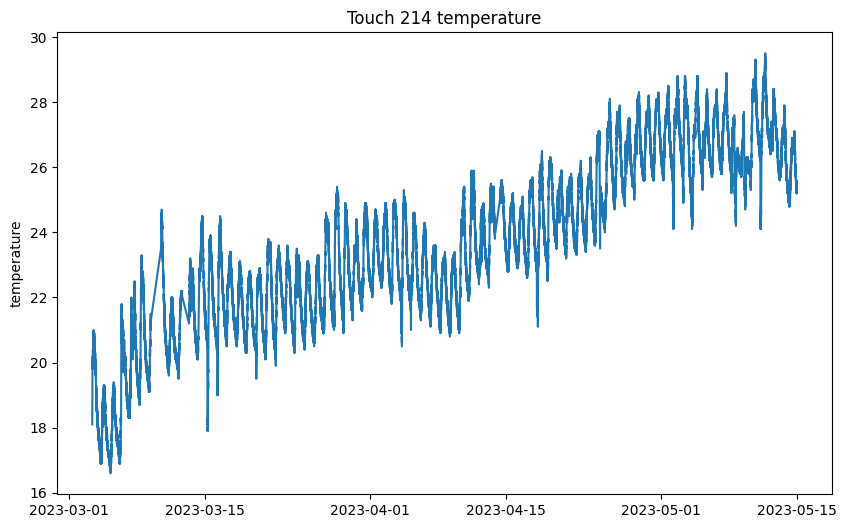

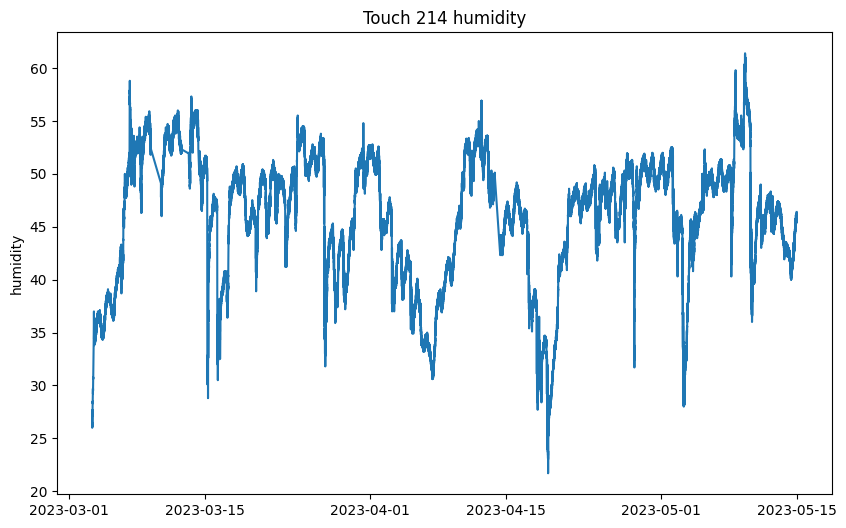

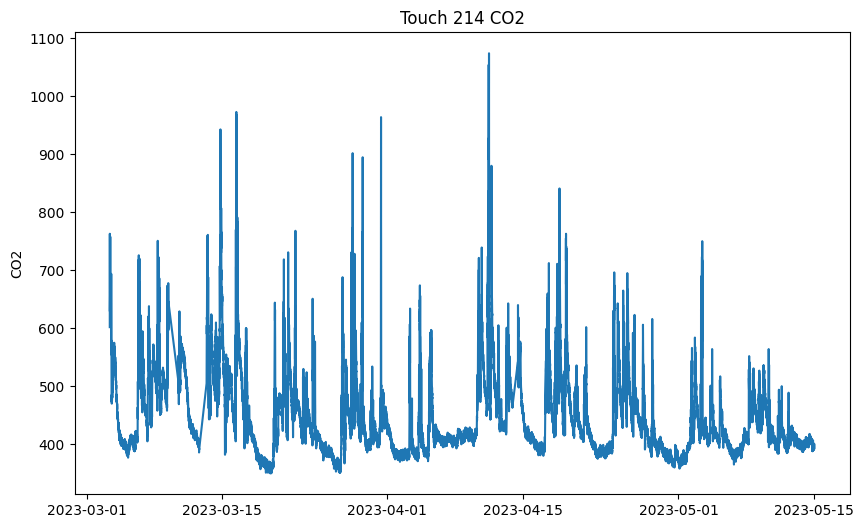

In [11]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_humidity, 'humidity')
plot_data(reduced_df_co2, 'CO2')

Registros duplicados

In [12]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [13]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_humidity = delete_duplicates(reduced_df_humidity, 'humidity')
reduced_df_co2 = delete_duplicates(reduced_df_co2, 'CO2')

temperature - Número de registros duplicados: 304
temperature - Número de registros tras eliminar duplicados:59028
humidity - Número de registros duplicados: 445
humidity - Número de registros tras eliminar duplicados:75003
CO2 - Número de registros duplicados: 452
CO2 - Número de registros tras eliminar duplicados:78449


In [14]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [15]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_humidity = fill_gaps_df(reduced_df_humidity, 'humidity')
reduced_df_co2 = fill_gaps_df(reduced_df_co2, 'CO2')

temperature - Original data:  59028 rows
temperature - Updated data:  104550 rows
humidity - Original data:  75003 rows
humidity - Updated data:  104550 rows
CO2 - Original data:  78449 rows
CO2 - Updated data:  104550 rows


In [16]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:31:00,18.100
2023-03-03 09:32:00,18.200
2023-03-03 09:33:00,18.300
2023-03-03 09:34:00,18.400
2023-03-03 09:35:00,18.500
...,...
2023-05-14 23:56:00,25.350
2023-05-14 23:57:00,25.375
2023-05-14 23:58:00,25.400


In [17]:
reduced_df_co2

,CO2
timestamp,
2023-03-03 09:30:00,601.92
2023-03-03 09:31:00,638.08
2023-03-03 09:32:00,673.28
2023-03-03 09:33:00,691.20
2023-03-03 09:34:00,730.88
...,...
2023-05-14 23:55:00,393.92
2023-05-14 23:56:00,394.40
2023-05-14 23:57:00,394.88


In [18]:
reduced_df_humidity

,humidity
timestamp,
2023-03-03 09:31:00,26.60
2023-03-03 09:32:00,26.80
2023-03-03 09:33:00,26.90
2023-03-03 09:34:00,26.80
2023-03-03 09:35:00,27.10
...,...
2023-05-14 23:56:00,46.12
2023-05-14 23:57:00,46.00
2023-05-14 23:58:00,45.80


Definimos datos de inicio y fin ignorando primer y último dia

In [19]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_humidity = reduced_df_humidity[(reduced_df_humidity.index >= '2023-03-06') & (reduced_df_humidity.index <= '2023-05-14')]
reduced_df_co2 = reduced_df_co2[(reduced_df_co2.index >= '2023-03-06') & (reduced_df_co2.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_humidity), len(reduced_df_co2)

(99361, 99361, 99361)

Normalizamos los datos

In [20]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [21]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_humidity, scaler_humidity = normalize_df(reduced_df_humidity)
reduced_df_co2, scaler_co2 = normalize_df(reduced_df_co2)

Por último, combinamos todos los datos en una misma tabla

In [22]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature,  reduced_df_humidity, reduced_df_co2], axis=1)
completed_df

,temperature,humidity,CO2
timestamp,,,
2023-03-06 00:00:00,0.055556,0.460957,0.060566
2023-03-06 00:01:00,0.059524,0.457179,0.063660
2023-03-06 00:02:00,0.063492,0.453401,0.062776
2023-03-06 00:03:00,0.059524,0.457809,0.061892
2023-03-06 00:04:00,0.055556,0.462217,0.060566
...,...,...,...
2023-05-13 23:56:00,0.698413,0.521411,0.067639
2023-05-13 23:57:00,0.682540,0.534509,0.067197
2023-05-13 23:58:00,0.690476,0.526448,0.066755


## Normalización de los valores + añadir periodicidad

In [23]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / day))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / day))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,humidity,CO2,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,
2023-03-06 00:00:00,0.055556,0.460957,0.060566,-1.267246e-11,1.000000,0.892796,0.450461
2023-03-06 00:01:00,0.059524,0.457179,0.063660,4.363309e-03,0.999990,0.892802,0.450450
2023-03-06 00:02:00,0.063492,0.453401,0.062776,8.726535e-03,0.999962,0.892807,0.450439
2023-03-06 00:03:00,0.059524,0.457809,0.061892,1.308960e-02,0.999914,0.892812,0.450429
2023-03-06 00:04:00,0.055556,0.462217,0.060566,1.745241e-02,0.999848,0.892818,0.450418
...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.698413,0.521411,0.067639,-1.745241e-02,0.999848,0.752028,-0.659131
2023-05-13 23:57:00,0.682540,0.534509,0.067197,-1.308960e-02,0.999914,0.752020,-0.659140
2023-05-13 23:58:00,0.690476,0.526448,0.066755,-8.726536e-03,0.999962,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [25]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [26]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 7), (99286, 45))

In [27]:
X

array([[[ 0.05555556,  0.46095718,  0.06056587, ...,  1.        ,
          0.89279631,  0.4504606 ],
        [ 0.05952381,  0.45717884,  0.06366048, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.06349206,  0.4534005 ,  0.0627763 , ...,  0.99996192,
          0.89280707,  0.45043927],
        ...,
        [ 0.0515873 ,  0.46788413,  0.05702918, ...,  0.96923091,
          0.89310284,  0.44985256],
        [ 0.0515873 ,  0.4697733 ,  0.05658709, ...,  0.96814764,
          0.89310821,  0.44984189],
        [ 0.04563492,  0.47166247,  0.05857648, ...,  0.96704594,
          0.89311358,  0.44983122]],

       [[ 0.05952381,  0.45717884,  0.06366048, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.06349206,  0.4534005 ,  0.0627763 , ...,  0.99996192,
          0.89280707,  0.45043927],
        [ 0.05952381,  0.45780856,  0.06189213, ...,  0.99991433,
          0.89281245,  0.45042861],
        ...,
        [ 0.0515873 ,  0.4697733 ,  0.05658709, ...,  

In [28]:
y

array([[0.03968254, 0.47355164, 0.06056587, ..., 0.04365079, 0.47607053,
        0.08576481],
       [0.04761905, 0.46725441, 0.05791335, ..., 0.04166667, 0.47670025,
        0.0826702 ],
       [0.05555556, 0.46095718, 0.06056587, ..., 0.03968254, 0.47732997,
        0.08399646],
       ...,
       [0.69444444, 0.5240974 , 0.0729443 , ..., 0.68253968, 0.53450882,
        0.06719717],
       [0.69246032, 0.52678421, 0.07029178, ..., 0.69047619, 0.52644836,
        0.06675508],
       [0.69047619, 0.52947103, 0.06984969, ..., 0.68650794, 0.52141058,
        0.066313  ]])

In [29]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [30]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │         2,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,357 (83.43 KB)

 Trainable params: 21,357 (83.43 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
modelPath = '../LSMTTensorflow/bestModelTouch214.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [32]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 0.0144 - mean_absolute_error: 0.0571 - root_mean_squared_error: 0.1024 - val_loss: 5.8415e-04 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0242
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 3.7957e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0195 - val_loss: 4.5083e-04 - val_mean_absolute_error: 0.0149 - val_root_mean_squared_error: 0.0212
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 3.4857e-04 - mean_absolute_error: 0.0102 - root_mean_squared_error: 0.0187 - val_loss: 4.6043e-04 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0215
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 3.2800e-04 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0181 - val_loss: 3.7524e-04 - val_mean_absolute_error: 0.0130 - val_root_mean_squared_error: 0.0194
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 3.16

In [33]:
HandMadeLSTM = load_model(modelPath)

In [34]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


(19858, 45)

In [35]:
y_test

array([[0.70634921, 0.74609572, 0.03448276, ..., 0.6984127 , 0.75314861,
        0.04774536],
       [0.6984127 , 0.75617128, 0.03183024, ..., 0.70634921, 0.73803526,
        0.04730327],
       [0.70634921, 0.74609572, 0.0331565 , ..., 0.6984127 , 0.74609572,
        0.04686118],
       ...,
       [0.69444444, 0.5240974 , 0.0729443 , ..., 0.68253968, 0.53450882,
        0.06719717],
       [0.69246032, 0.52678421, 0.07029178, ..., 0.69047619, 0.52644836,
        0.06675508],
       [0.69047619, 0.52947103, 0.06984969, ..., 0.68650794, 0.52141058,
        0.066313  ]])

In [36]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::3]).flatten()
    test_predictions_humidity = scaler_humidity.inverse_transform(predictions[:, 1::3]).flatten()
    test_predictions_co2 = scaler_co2.inverse_transform(predictions[:, 2::3]).flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::3]).flatten()
    y_test_humidity = scaler_humidity.inverse_transform(test[:, 1::3]).flatten()
    y_test_co2 = scaler_co2.inverse_transform(test[:, 2::3]).flatten()
    
    return test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2

test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(test_predictions, y_test)

In [37]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Touch 214 ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:1440], label='True')
    plt.plot(test_predictions[:1440], label='Predicted')
    plt.title('Touch 214 ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

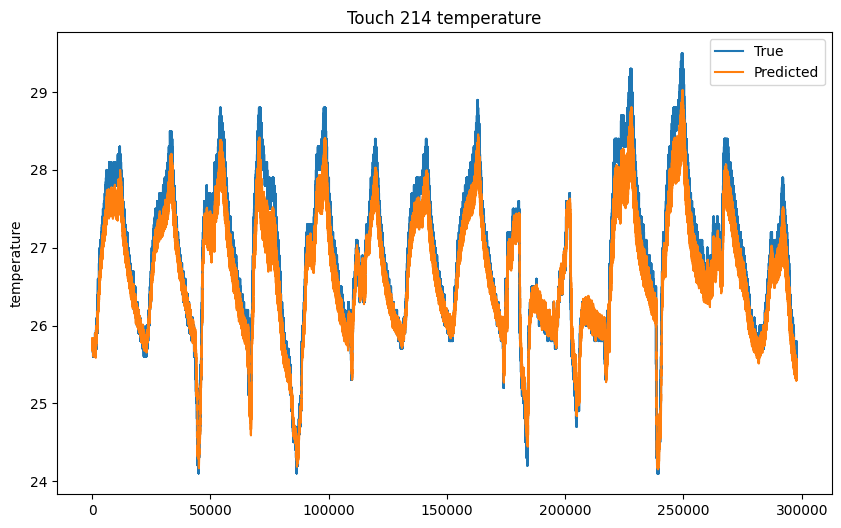

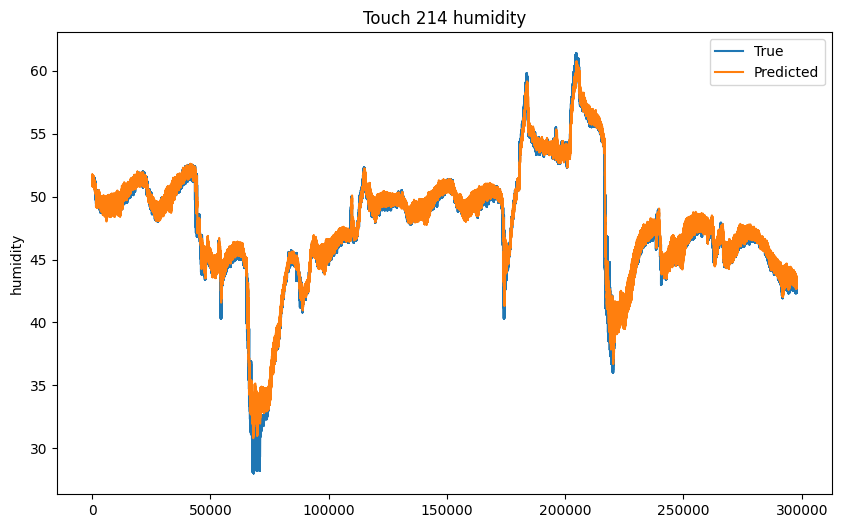

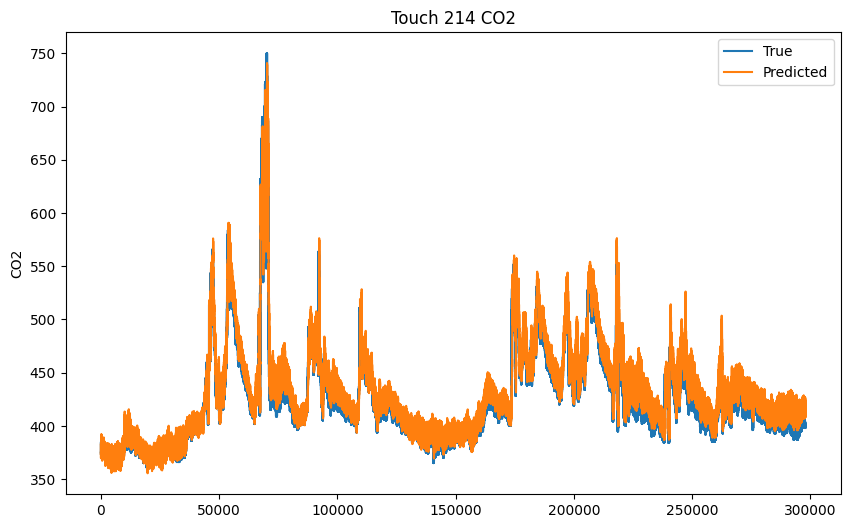

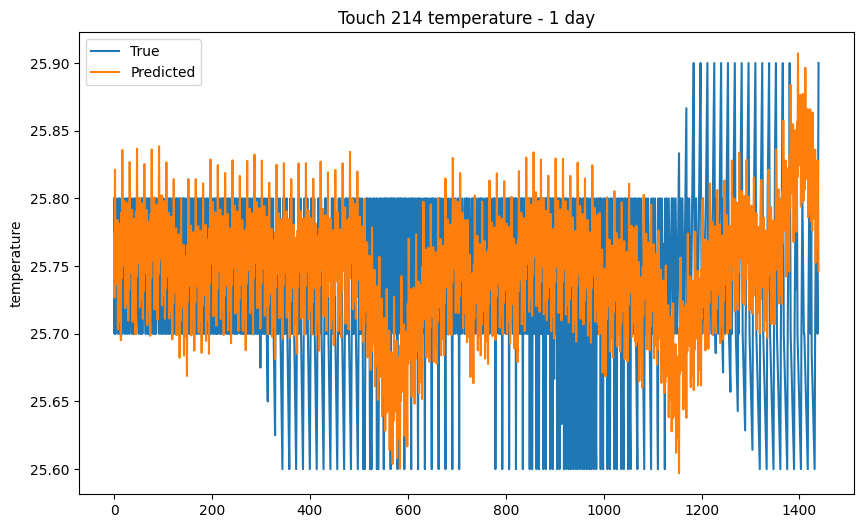

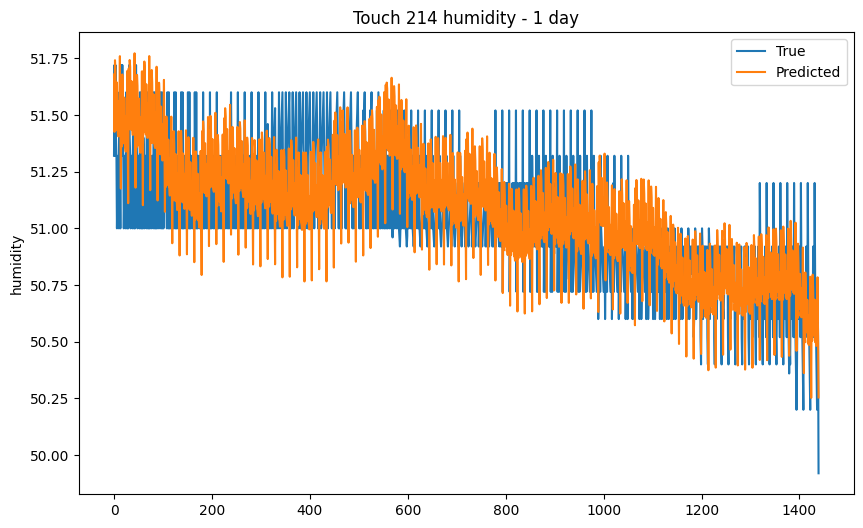

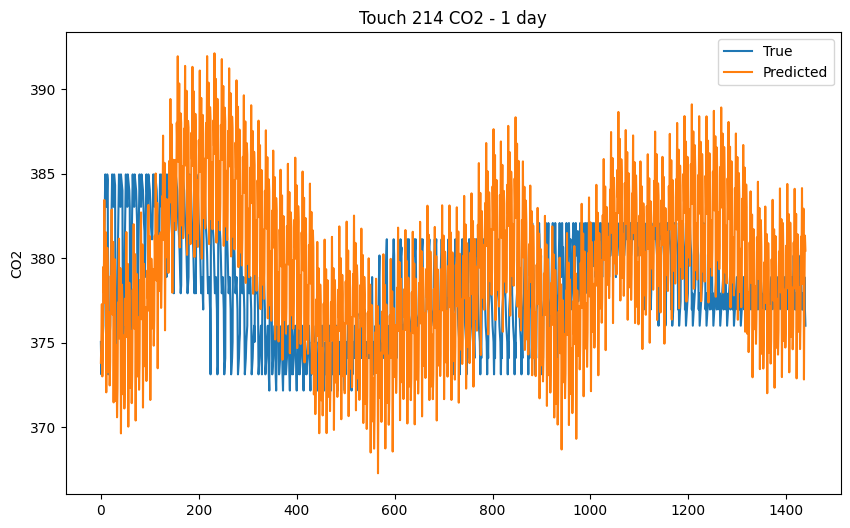

In [38]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')

In [39]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')

temperature - MSE: 0.10441039686126376
temperature - MAE: 0.25379760155747183
temperature - RMSE: 0.3231259767664367
humidity - MSE: 0.487376703494371
humidity - MAE: 0.4697525228523295
humidity - RMSE: 0.6981237021433745
CO2 - MSE: 261.2286748215483
CO2 - MAE: 12.297720859093367
CO2 - RMSE: 16.162570179941934


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [40]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0259 - mean_absolute_error: 0.0889 - root_mean_squared_error: 0.1432 - val_loss: 0.0010 - val_mean_absolute_error: 0.0217 - val_root_mean_squared_error: 0.0323
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step - loss: 9.1552e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0303 - val_loss: 9.0822e-04 - val_mean_absolute_error: 0.0204 - val_root_mean_squared_error: 0.0301
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - loss: 8.8645e-04 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0298 - val_loss: 8.0061e-04 - val_mean_absolute_error: 0.0180 - val_root_mean_squared_error: 0.0283
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step - loss: 8.5753e-04 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0293 - val_loss: 7.2854e-04 - val_mean_absolute_error: 0.0162 - val_root_mean_squared_error: 0.0270
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - loss: 8.4873e-04

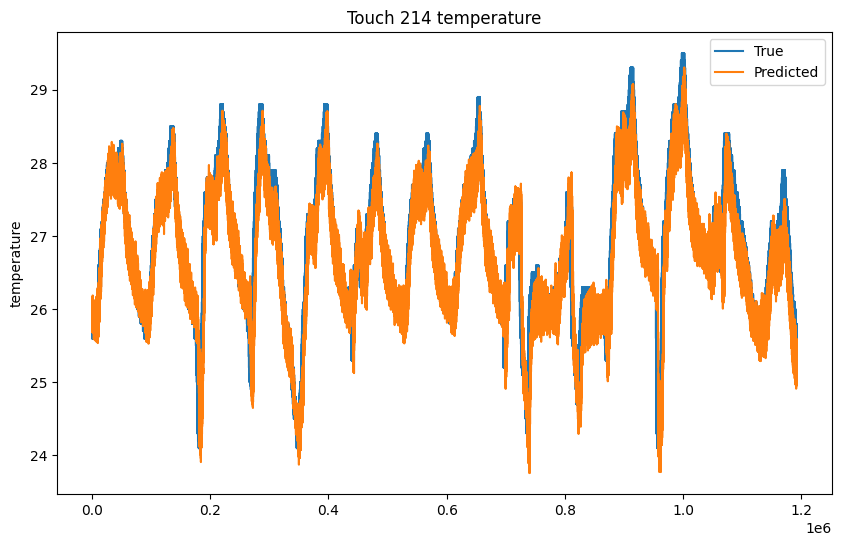

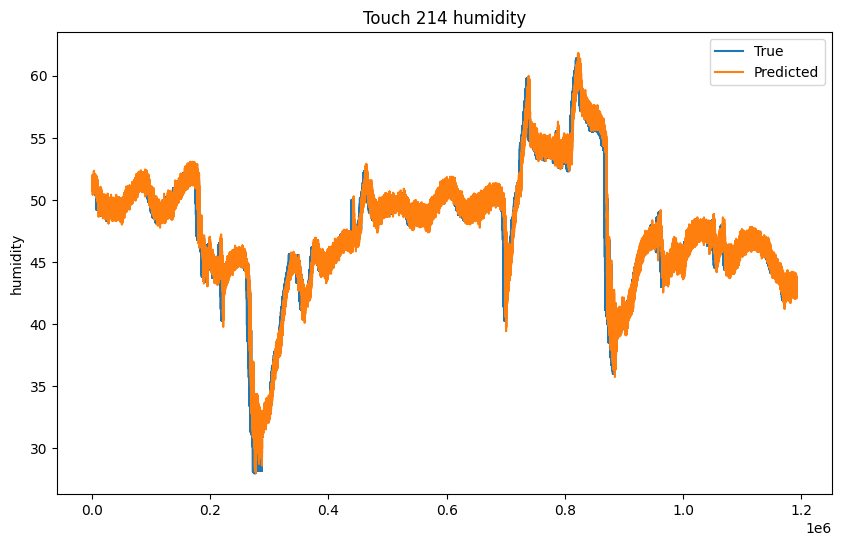

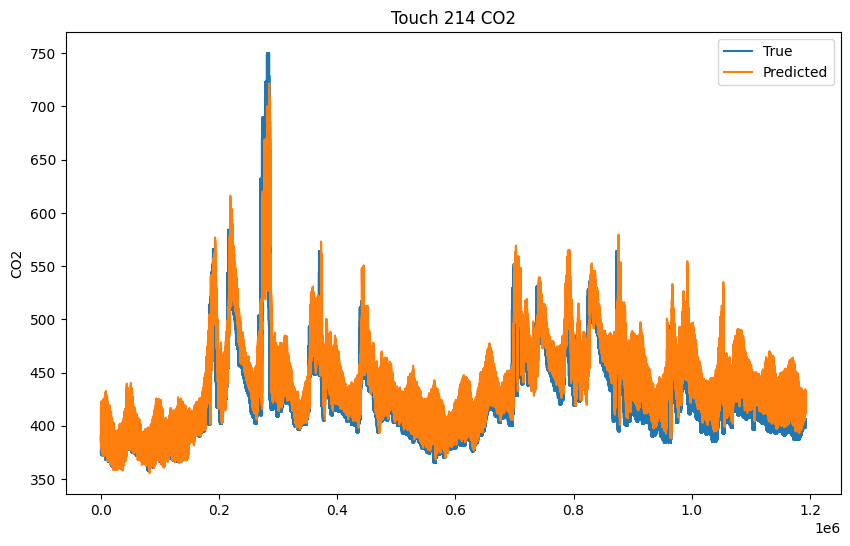

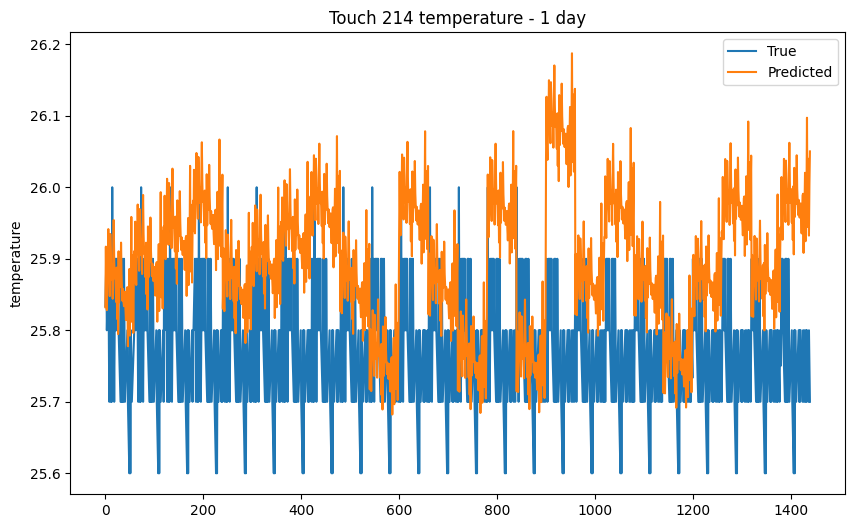

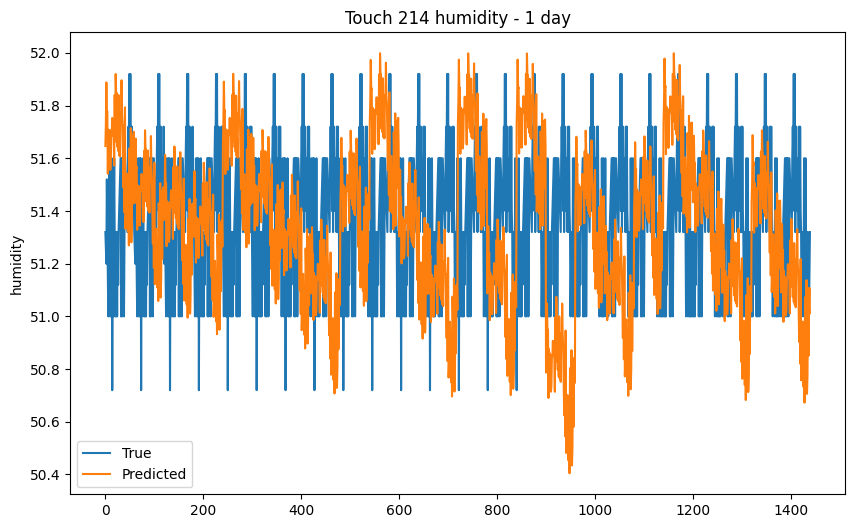

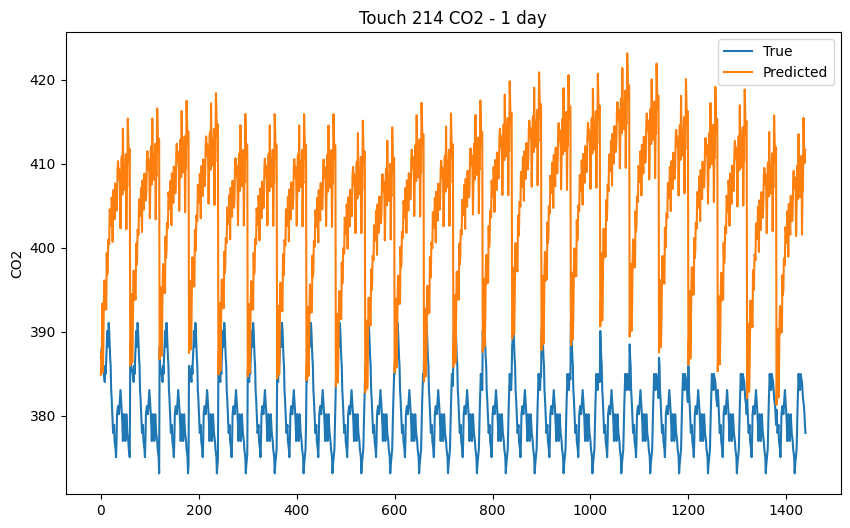

temperature - MSE: 0.11636654698526218
temperature - MAE: 0.24869344725007891
temperature - RMSE: 0.3411254124002816
humidity - MSE: 0.8002159893702526
humidity - MAE: 0.538931634919951
humidity - RMSE: 0.8945479245799258
CO2 - MSE: 957.5414422529317
CO2 - MAE: 25.397001493018124
CO2 - RMSE: 30.94416653026757
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0279 - mean_absolute_error: 0.0980 - root_mean_squared_error: 0.1507 - val_loss: 0.0032 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0562
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0030 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0548 - val_loss: 0.0034 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0583
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0027 - mean_absolute_error: 0.0311 - root_mean_squared_error: 0.0522 - val_loss: 0.0036 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0598
Epoch 4/20
1986/1

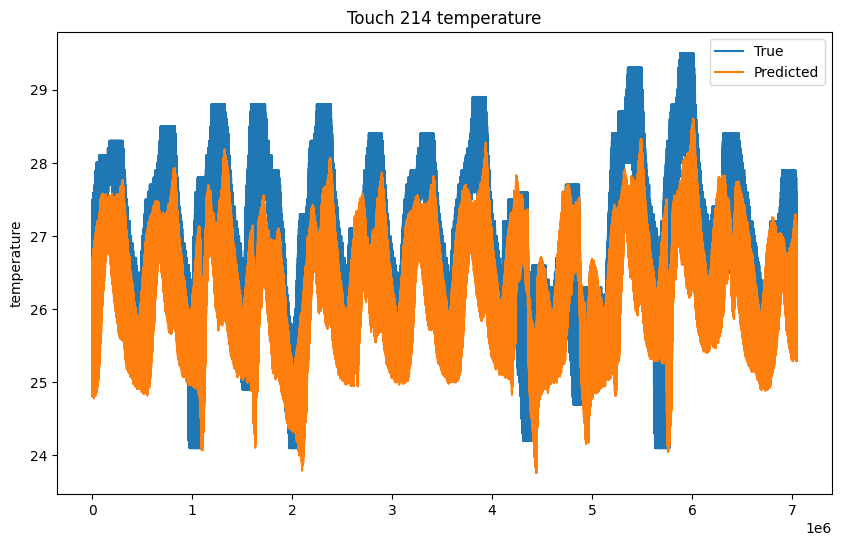

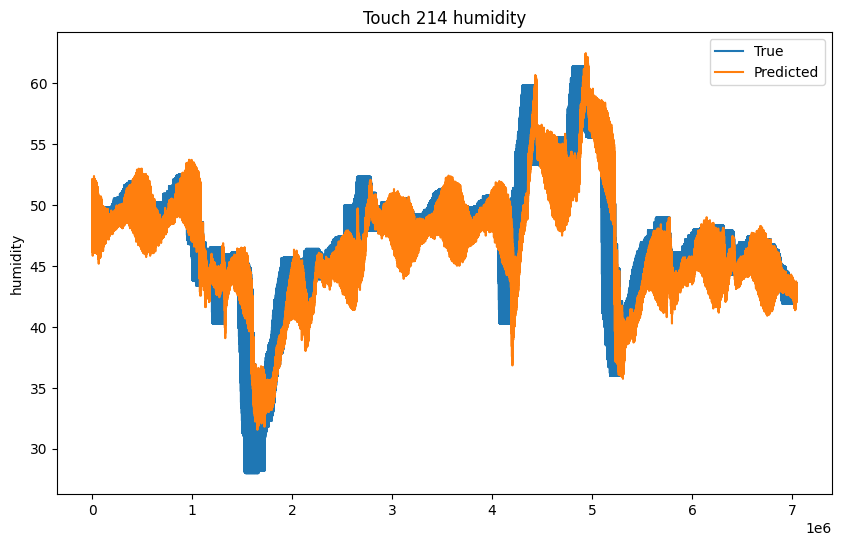

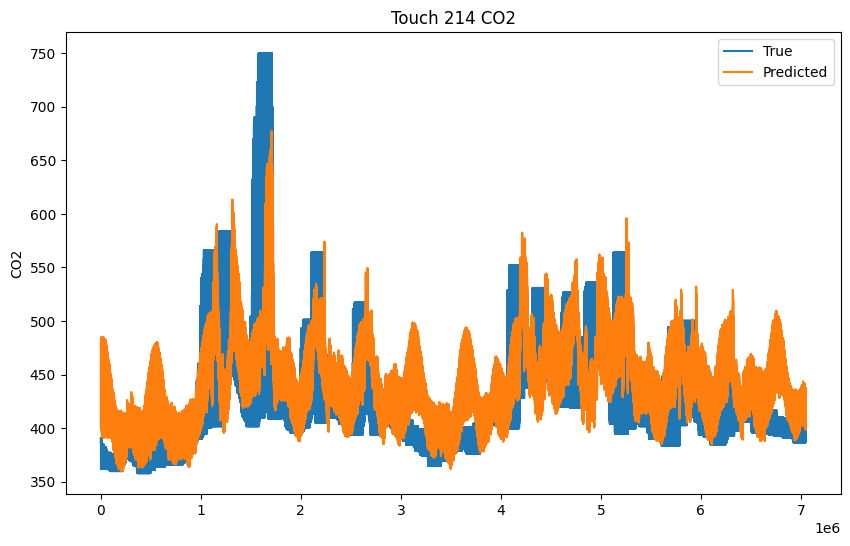

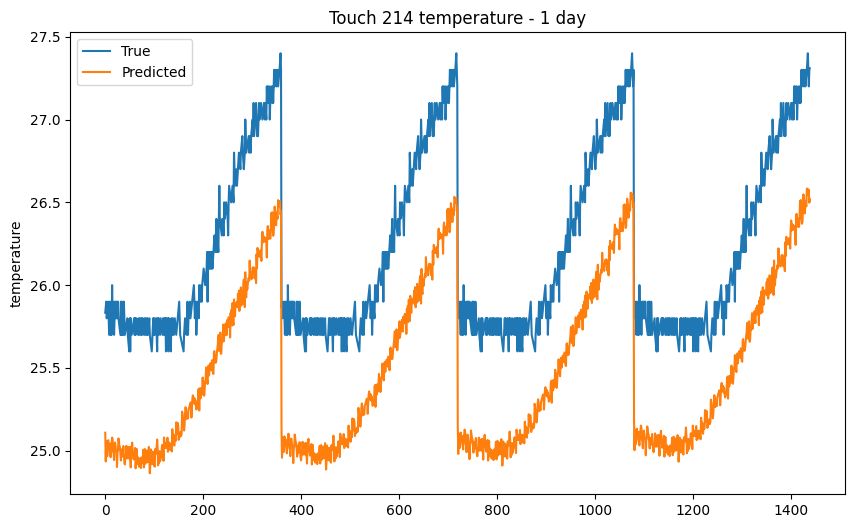

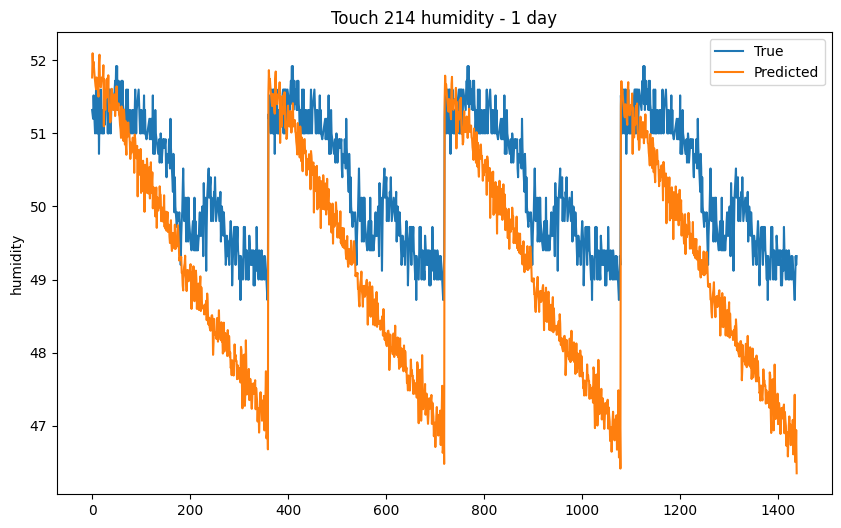

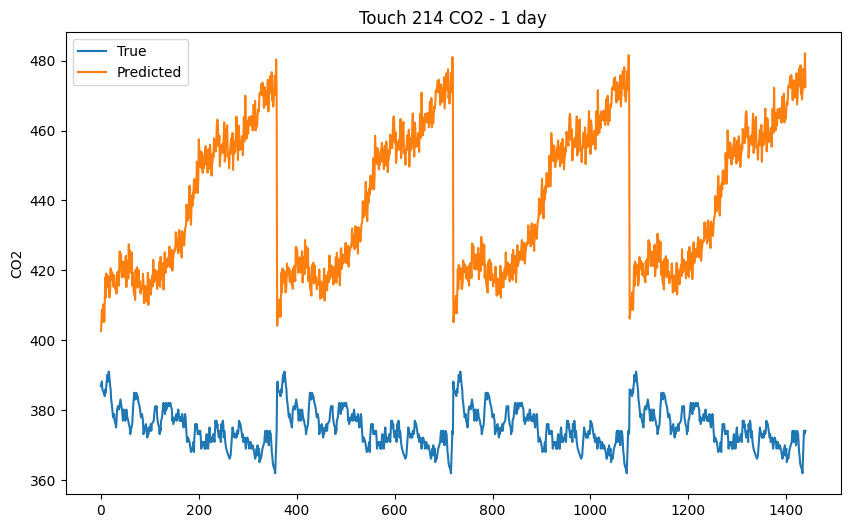

temperature - MSE: 0.8621312891646551
temperature - MAE: 0.8081206188443049
temperature - RMSE: 0.9285102525899512
humidity - MSE: 6.162813062636071
humidity - MAE: 1.6247125918892191
humidity - RMSE: 2.48250137213176
CO2 - MSE: 1561.3938400374311
CO2 - MAE: 29.112062615879378
CO2 - RMSE: 39.514476335103204
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0283 - mean_absolute_error: 0.1007 - root_mean_squared_error: 0.1528 - val_loss: 0.0053 - val_mean_absolute_error: 0.0543 - val_root_mean_squared_error: 0.0730
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0643 - val_loss: 0.0044 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0661
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0037 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0611 - val_loss: 0.0048 - val_mean_absolute_error: 0.0498 - val_root_mean_squared_error: 0.0690
Epoch 4/20
1986/198

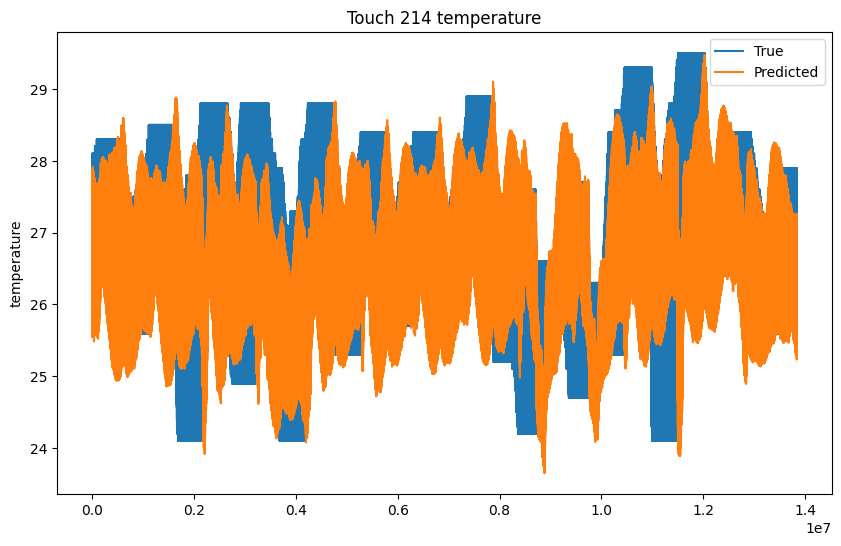

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


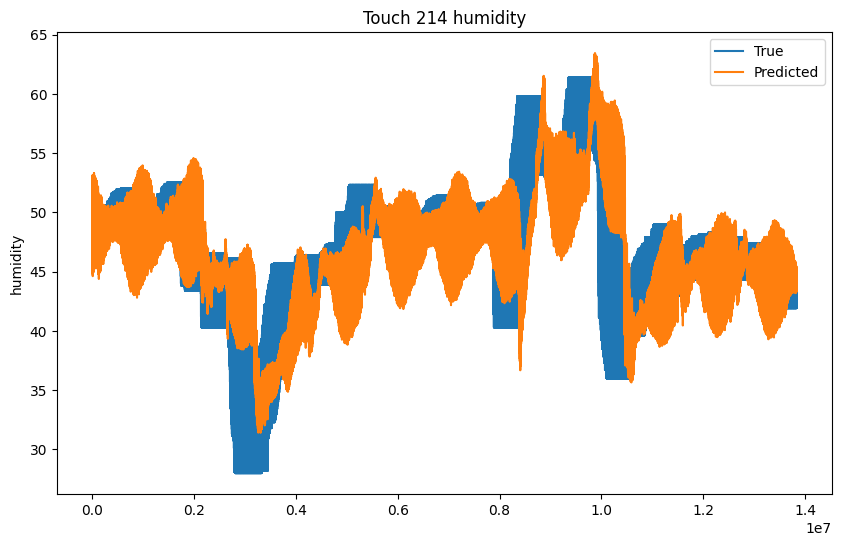

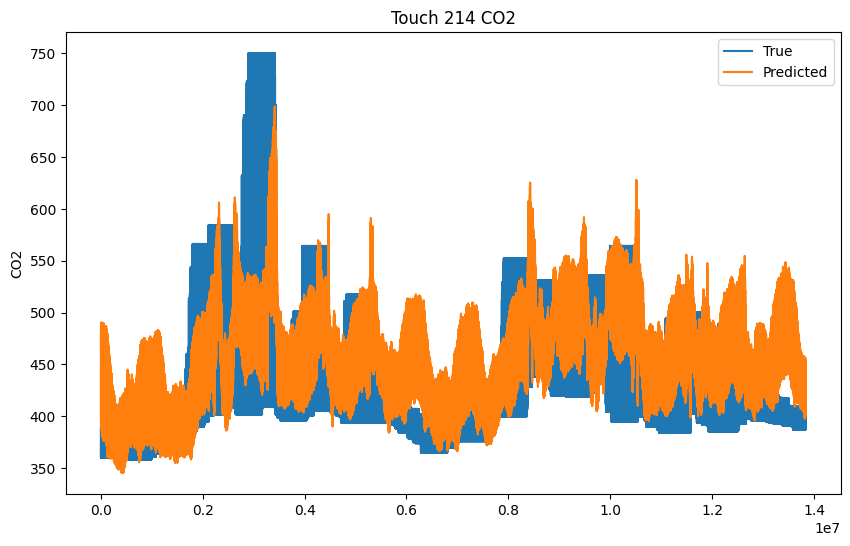

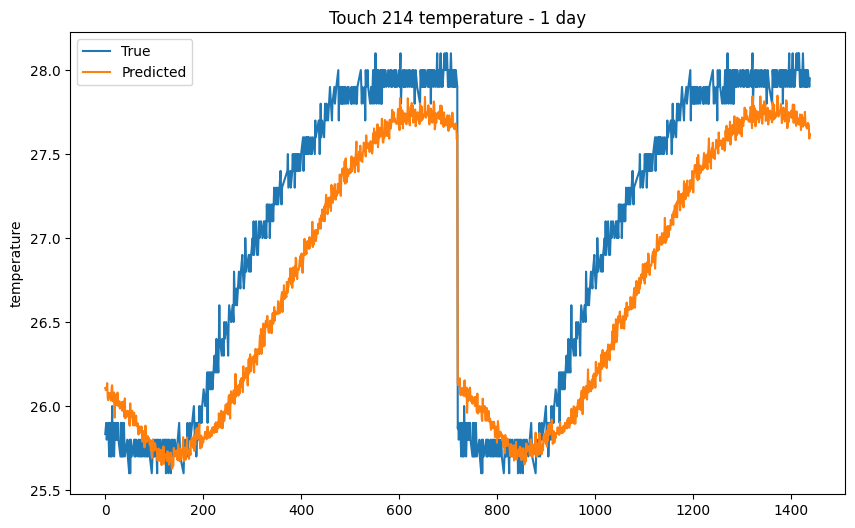

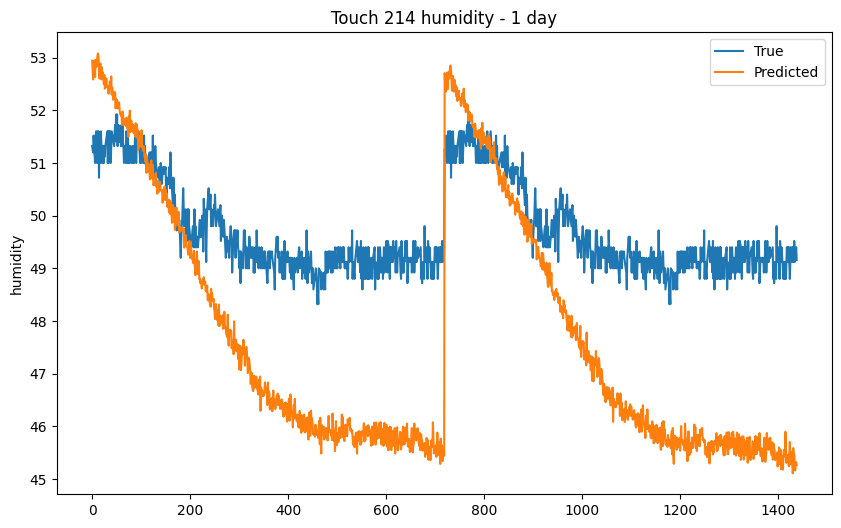

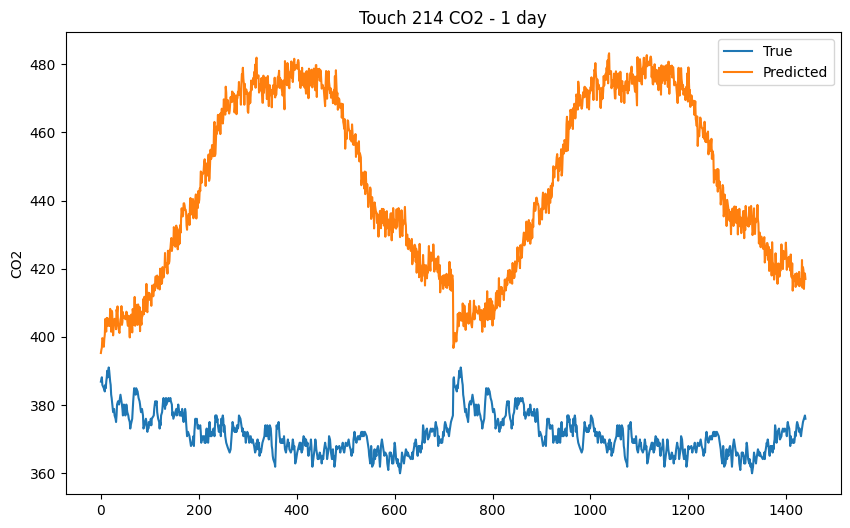

temperature - MSE: 0.7282524724795132
temperature - MAE: 0.6467850166872637
temperature - RMSE: 0.8533770986378256
humidity - MSE: 13.505809888346194
humidity - MAE: 2.5949605327888117
humidity - RMSE: 3.675025154790943
CO2 - MSE: 2731.6945925822947
CO2 - MAE: 42.945408864364964
CO2 - RMSE: 52.2656157773186


In [41]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_touch_214_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')
    
    

In [42]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/touch/scaler_temperature_touch_214.pkl', 'wb'))
dump(scaler_humidity, open('scalers/touch/scaler_humidity_touch_214.pkl', 'wb'))
dump(scaler_co2, open('scalers/touch/scaler_co2_touch_214.pkl', 'wb'))


In [43]:
scaler_temperature.data_max_, scaler_humidity.data_max_, scaler_co2.data_max_, scaler_temperature.data_min_, scaler_humidity.data_min_, scaler_co2.data_min_

(array([29.5]),
 array([61.4]),
 array([1073.92]),
 array([16.9]),
 array([21.7]),
 array([350.08]))